# G27
Dave Brunner

In [81]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchinfo import summary # with torchsummary we got a bug, consider installing torchinfo
from torch.utils.data import DataLoader, TensorDataset # lets us load data in batches

In [82]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


In [83]:
# wget the file from https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
with open("companies.csv") as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
print("Loaded a corpus of {0} characters".format(corpus_length))

Loaded a corpus of 2567986 characters


In [84]:
print(corpus[:100])

Hashplay Inc.
New Incentives
GrabJobs
MediBookr
MelissaWithLove.co
Starting 11
The CarShare Guy
Alla


In [85]:
# Get a unique identifier for each char in the corpus, 
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 150 unique characters.


In [86]:
print(f'Decoding: {decoding}')
print(f'Encoding: {encoding}')

Decoding: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: '+', 13: ',', 14: '-', 15: '.', 16: '/', 17: '0', 18: '1', 19: '2', 20: '3', 21: '4', 22: '5', 23: '6', 24: '7', 25: '8', 26: '9', 27: ':', 28: '=', 29: '>', 30: '?', 31: '@', 32: 'A', 33: 'B', 34: 'C', 35: 'D', 36: 'E', 37: 'F', 38: 'G', 39: 'H', 40: 'I', 41: 'J', 42: 'K', 43: 'L', 44: 'M', 45: 'N', 46: 'O', 47: 'P', 48: 'Q', 49: 'R', 50: 'S', 51: 'T', 52: 'U', 53: 'V', 54: 'W', 55: 'X', 56: 'Y', 57: 'Z', 58: '[', 59: '\\', 60: ']', 61: '^', 62: '_', 63: 'a', 64: 'b', 65: 'c', 66: 'd', 67: 'e', 68: 'f', 69: 'g', 70: 'h', 71: 'i', 72: 'j', 73: 'k', 74: 'l', 75: 'm', 76: 'n', 77: 'o', 78: 'p', 79: 'q', 80: 'r', 81: 's', 82: 't', 83: 'u', 84: 'v', 85: 'w', 86: 'x', 87: 'y', 88: 'z', 89: '{', 90: '|', 91: '}', 92: '~', 93: '\x81', 94: '\x82', 95: '\x83', 96: '\x84', 97: '\x85', 98: '\x86', 99: '\x87', 100: '\x88', 101: '\x89', 102: '\x8a', 103: '\x8b', 104: '\x8c', 105: '\x8d'

In [87]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 10
skip = 3
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 855992 sentences of length 10


In [88]:
print(X_data[0])
print([decoding[idx] for idx in X_data[0]])
print(decoding[y_data[0]])

[39, 63, 81, 70, 78, 74, 63, 87, 1, 40]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
n


In [89]:
# One-hot encode the data.
X = F.one_hot(torch.tensor(X_data), num_classes=num_chars).to(torch.float)
y = torch.tensor(y_data) #No need to encode labels in one-hot with pytorch,
                         #crossEntropy loss needs just the indexes (not 0-1 values)


# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}"
      .format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}"
      .format(X.size(), sentence_length))

Sanity check y. Dimension: torch.Size([855992]) # Sentences: 855992 Characters in corpus: 150
Sanity check X. Dimension: torch.Size([855992, 10, 150]) Sentence length: 10


In [90]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, hidden = self.rnn(x)
        out = out[:, -1]
        out = self.fc(out)
        return out

In [91]:
def train(n_epochs, model, data_loader, optimizer, criterion, log_interval=200):
    # Keep track of stats to plot them
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(1, n_epochs + 1):
        model.train()
        total_train_loss = 0
        total_correct = 0 
        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad() 
            # Pass data through the network
            output = model(data)
    
            # Calculate loss
            loss = criterion(output, target)
            # Backpropagate. Updates the gradients buffer on each parameter
            loss.backward()
            # Update weights
            optimizer.step()
            
            total_train_loss += loss.item()
            
            _, pred = torch.max(output, dim=1)
    
            total_correct += torch.sum(pred == target).item()
        
        accuracy_train = total_correct / len(data_loader.dataset)
    
        
        total_train_loss = total_train_loss / len(data_loader)
    
        print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, total_train_loss),
        ', Accuracy: {}'.format(accuracy_train))
        train_losses.append(total_train_loss)
        train_accuracies.append(accuracy_train)

    return {
        "loss": train_losses,
        "accuracy": train_accuracies,
    }

def plot_history(history):
    plt.plot(history['loss'], label='Training loss')
    plt.legend()
    plt.grid()
    plt.show()

In [53]:
# Create dataloader from X,y tensors
dataset = TensorDataset(X, y)
n_classes = len(chars)
seq_length = 10

In [54]:
hidden_size = 64
batch_size = 128
n_layers = 1
n_epochs = 7

model_1 = RNN(num_chars, hidden_size, num_chars, n_layers).to(device)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

history = train(n_epochs, model_1, train_loader, optimizer, criteria)

Train Epoch: 1 	Loss: 2.602636 , Accuracy: 0.27566495948560266
Train Epoch: 2 	Loss: 2.286826 , Accuracy: 0.351899316816045
Train Epoch: 3 	Loss: 2.220348 , Accuracy: 0.369997616800157
Train Epoch: 4 	Loss: 2.185460 , Accuracy: 0.3801297208385125
Train Epoch: 5 	Loss: 2.162903 , Accuracy: 0.3858704286955953
Train Epoch: 6 	Loss: 2.147159 , Accuracy: 0.39062280955896783
Train Epoch: 7 	Loss: 2.135066 , Accuracy: 0.3934265740801316


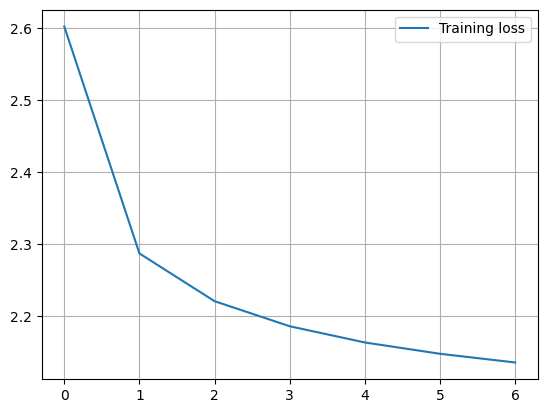

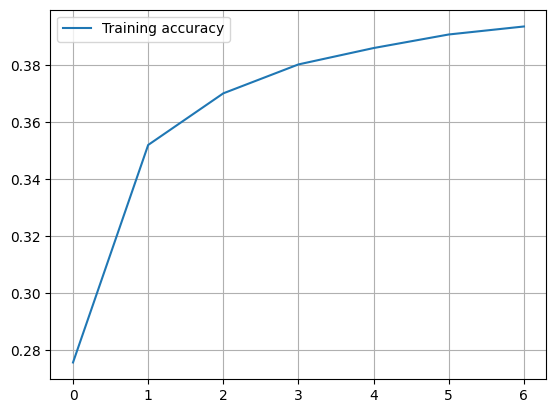

In [55]:
plot_history(history)

In [56]:
hidden_size = 128
batch_size = 128
n_layers = 1
n_epochs = 10

model_2 = RNN(num_chars, hidden_size, num_chars, n_layers).to(device)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

history_2 = train(n_epochs, model_2, train_loader, optimizer, criteria)

Train Epoch: 1 	Loss: 2.493799 , Accuracy: 0.30331007766427726
Train Epoch: 2 	Loss: 2.196287 , Accuracy: 0.37674884812007586
Train Epoch: 3 	Loss: 2.120454 , Accuracy: 0.39808315965569774
Train Epoch: 4 	Loss: 2.077373 , Accuracy: 0.4093951812633763
Train Epoch: 5 	Loss: 2.049825 , Accuracy: 0.4169361395900896
Train Epoch: 6 	Loss: 2.029864 , Accuracy: 0.4221009074851167
Train Epoch: 7 	Loss: 2.015196 , Accuracy: 0.42654020131029263
Train Epoch: 8 	Loss: 2.003410 , Accuracy: 0.4303194422377779
Train Epoch: 9 	Loss: 1.993491 , Accuracy: 0.43211735623697417
Train Epoch: 10 	Loss: 1.985768 , Accuracy: 0.43472252077122214


In [ ]:
plot_history(history_2)

In [57]:
@torch.inference_mode() 
def predict(model, data):
    # Put the model in eval mode, which disables training specific behaviour.
    model.eval()
    output = model(data)
    return output


def make_seed(seed_phrase=""):
        if seed_phrase:  # make sure the seed has the right length
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            # sample randomly the seed from corpus
            seed = random.randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]
        return pattern
    
def generate(model, seed_phrase=""):
    # Set the model to evaluation
    seed_pattern = make_seed(seed_phrase)
    print("seed = " + seed_pattern)
    
    encoded_text = torch.tensor([encoding[char] for char in seed_pattern])
    encoded_text = F.one_hot(encoded_text, num_classes=num_chars).to(torch.float)
    # Add a single batch dimension at the beginning
    encoded_text = encoded_text.unsqueeze(0)
    encoded_text = encoded_text.to(device)
    
    generated_text = ""
    for i in range(500):
        # predict() gives a tensor of shape (1, 65) 
        # with 1 being the size of the batch, for that we use [0] to get a vector
        output = predict(model, encoded_text)[0]
        # Convert the output to probabilities
        probs = torch.softmax(output, dim=-1)
        # Randomly choose from a multinomial distribution with the output probabilities
        # make the generation more diverse.
        prediction = torch.multinomial(probs, num_samples=1)
        generated_text += decoding[int(prediction)]
        
        # One hot encode the new (predicted) character
        next_char_encoded = F.one_hot(prediction, num_classes=num_chars)
        # Make sure it has a singular batch and seq_len dimension in order to concatenate them.
        next_char_encoded = next_char_encoded.view(1, 1, num_chars)
        # Remove first char and glue the predicted one to the end
        encoded_text = torch.cat((encoded_text[:, 1:], next_char_encoded), dim=1)
    return generated_text

In [62]:
generated_text = generate(model_1, "Tech Water Company")
print(generated_text)

seed = Tech Water
ss
Brokant Manowor Findners Selvices
INPSALI
Globas
Vulva
OB Oynal Oniame Masza old
Fahybrup
Largee'suling Tredgty
Emivalmage Therapeu' FITICNE
Vrectse Holdisment Doficl
Phalma3
Orknane Heastora
PoeficcASTPWS
Ederexin
Beadlion
FieMC Ltd.
MotrondoTaceut
DSC Incheluts
Fuver
BipA Inc.
Sacperware
Haltaron Group
PDAR
Endemnty Sanetion
Applitionces Ltd.
OreDeter
Mugand AB
Purynew Stueres
Debia
Dhytas Corporation Lateriaw Cryss
Bolegribs
Bruew Corpo
Fashlinip Solutions
Careno
MictercSebergy
ThingBale O


In [61]:
generated_text = generate(model_2, "Tech Water Company")
print(generated_text)

seed = Tech Water
ne
Mutcratch
Tacker Partnens
ACIVITNENCH
ing Resource
Pitau IX
Spree.com
SafeDald Energy Term Green
PRUSNA
Pvtaviaran Mogur
Welltrics
Prime Woviclink
Dliphold Researchung Manager
Scorfierz
UNA Capital
CDretPlant Capang CapPessle Insortics
Argago
Leta Collective
PlayFheack Productsui
Kawbotch"
OBily Fard Weldsi
BaicIaugon
OxGamen Pathoup
Stapplo
Otter
ikercCap
Siardomet
ARZP
Cocnovile
geinix
Cey/Catronng
Clook Sive Tech ol Group
Steala Balla Acrus
The InVenies Systems
Offine Sancels
J.A.
Orbertua


### Interesting startup names:
For seed: Tech Water Company
###### (with 8 epochs, 64 hidden units, 128 batch size, 0.001 learning rate)
- Debia
- Careno
- Phalma3
- Beadlion

###### (with 10 epochs, 128 hidden units, 128 batch size, 0.001 learning rate)
- PRUSNA
- UNA Capital
- Arago

In [77]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, hidden = self.rnn(x)
        out = out[:, -1]
        out = self.fc(out)
        return out

In [98]:
hidden_size = 64
batch_size = 128
n_layers = 1
n_epochs = 10

lstm_1 = LSTM(num_chars, hidden_size, num_chars, n_layers).to(device)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_1.parameters(), lr=0.001)

history_3 = train(n_epochs, lstm_1, train_loader, optimizer, criteria)

Train Epoch: 1 	Loss: 2.698255 , Accuracy: 0.2502056093982187
Train Epoch: 2 	Loss: 2.305877 , Accuracy: 0.3466854830418976
Train Epoch: 3 	Loss: 2.189147 , Accuracy: 0.37944163029561023
Train Epoch: 4 	Loss: 2.124464 , Accuracy: 0.3966088468116524
Train Epoch: 5 	Loss: 2.082287 , Accuracy: 0.40838816250619164
Train Epoch: 6 	Loss: 2.052335 , Accuracy: 0.41690927018009516
Train Epoch: 7 	Loss: 2.029473 , Accuracy: 0.42322358152879935
Train Epoch: 8 	Loss: 2.010892 , Accuracy: 0.42747362124879673
Train Epoch: 9 	Loss: 1.995508 , Accuracy: 0.43210100094393405
Train Epoch: 10 	Loss: 1.982359 , Accuracy: 0.4354795371919364


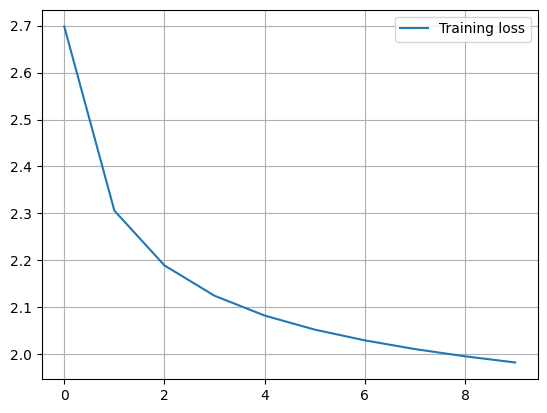

In [99]:
plot_history(history_3)

In [100]:
generated_text = generate(lstm_1, "Tech Water Company")
print(generated_text)

seed = Tech Water
s
LeumerPurmon
Buzix Worps
Uph Theean
Teln Holdd
Enimpting Corporation
"Smalthconts
Anta
MidabienPro
Squars Corporation
KCN and Plan lS Therapoytes)
MedionVia
Avent
The Gland
-AC.O
Rigbi, Inc."
Clinage Petlecion Jath
Drupe
Consuring Business
Vilker
Data Direct Pharma
edimitac (Hoadbana
Net Artures
Bata Central
SynalEnquitac Later
BIDNEP Company,
Nepower
Annetsworde
Create10 Partners
PudWorlsbox
OpHellea
Beanific
SbHDwazz
Mone BM n Resort
Melgomo
OveEdan Group
Reytourtron HoGell Power Ltd
Fist
Be


The loss of this LSTM is at the same level as the RNN model.

Som interesting names generated by the LSTM model (for seed: Tech Water Company):
- Vilker
- Nepower

# New dataset


In [113]:
# wget the file from https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
with open("spotify_millsongdata.csv") as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
print("Loaded a corpus of {0} characters".format(corpus_length))

Loaded a corpus of 955254 characters


In [114]:
# Get a unique identifier for each char in the corpus, 
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))
print(corpus[:100])

Our corpus contains 76 unique characters.
Ahe's My Kind Of Girl
"Andante, Andante"
As Good As New
Bang
Bang-A-Boomerang
Burning My Bridges
Cas


In [115]:
sentence_length = 10
skip = 3
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))
print(X_data[0])
print([decoding[idx] for idx in X_data[0]])
print(decoding[y_data[0]])
X = F.one_hot(torch.tensor(X_data), num_classes=num_chars).to(torch.float)
y = torch.tensor(y_data) 
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}"
      .format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}"
      .format(X.size(), sentence_length))

Sliced our corpus into 318415 sentences of length 10
[22, 57, 54, 4, 68, 1, 34, 74, 1, 32]
['A', 'h', 'e', "'", 's', ' ', 'M', 'y', ' ', 'K']
i
Sanity check y. Dimension: torch.Size([318415]) # Sentences: 318415 Characters in corpus: 76
Sanity check X. Dimension: torch.Size([318415, 10, 76]) Sentence length: 10


In [116]:
# Create dataloader from X,y tensors
dataset = TensorDataset(X, y)
n_classes = len(chars)
seq_length = 10

In [121]:
hidden_size = 84
batch_size = 128
n_layers = 2
n_epochs = 10

model_spotify = LSTM(num_chars, hidden_size, num_chars, n_layers).to(device)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_spotify.parameters(), lr=0.001)

history = train(n_epochs, model_spotify, train_loader, optimizer, criteria)

Train Epoch: 1 	Loss: 2.601164 , Accuracy: 0.2630435123973431
Train Epoch: 2 	Loss: 2.118533 , Accuracy: 0.36735392490931645
Train Epoch: 3 	Loss: 1.948216 , Accuracy: 0.41509979115305495
Train Epoch: 4 	Loss: 1.841169 , Accuracy: 0.4449539123470942
Train Epoch: 5 	Loss: 1.768172 , Accuracy: 0.464481886845783
Train Epoch: 6 	Loss: 1.715039 , Accuracy: 0.4786960413297112
Train Epoch: 7 	Loss: 1.672410 , Accuracy: 0.49008055525022376
Train Epoch: 8 	Loss: 1.637926 , Accuracy: 0.49963098472119716
Train Epoch: 9 	Loss: 1.607820 , Accuracy: 0.5081701553004726
Train Epoch: 10 	Loss: 1.582077 , Accuracy: 0.5156855047657931


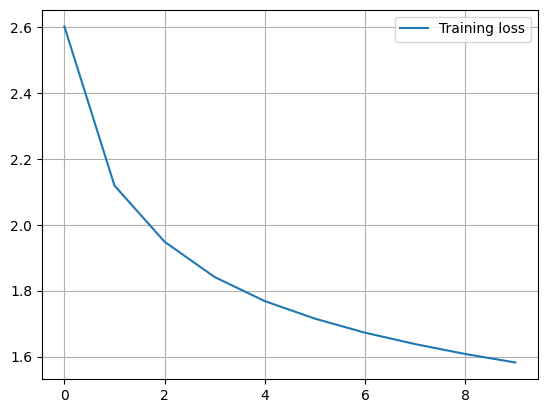

In [122]:
plot_history(history)

In [123]:
generated_text = generate(model_spotify, "The code")
print(generated_text)

seed = The codeTh
ing
Bil Staye For You
It's At All
How Hand In The Mouth Spelleble
Johnny Dark Your More
Naturall
Millty Step
Hand In The Tite
Have It
Thror Lund Time
Pussobakation Again
It's Alone
I'm Begins
Ik On You
Brokens Like Nack
Becweet Its't A City
Calmer Is A Chuncine Blard Shonelash
"Come On Me
Come Down
Opery Remibe
Godod
Jockay Day, Have For Morriend
Stryn' Have You
A Better Hearts
Korkin'
Over Lets Me Go
Jubitions"
Fulling Childredader
She The Roade
Lone Like Till
Back It Stars
The Poontion
Not Bar
